In [1]:
import numpy as np
import pandas as pd

In [2]:
from ESRNN.m4_data import *
from ESRNN.utils_evaluation import evaluate_prediction_owa
from ESRNN.utils_visualization import plot_grid_prediction

In [4]:
X_train_df, y_train_df, X_test_df, y_test_df = prepare_m4_data(dataset_name="Hourly",
                                                               directory="../data/M4",
                                                               num_obs=414)

In [4]:
prediction_length = 48

In [5]:
index_cutoffs = [48*i for i in range(7, 0, -1)]
index_cutoffs

[336, 288, 240, 192, 144, 96, 48]

In [6]:
cutoffs = [y_train_df.groupby('unique_id')['ds'].transform(lambda x: x.max() - pd.Timedelta(hours=index_cutoff)) for index_cutoff in index_cutoffs]
ceilings = [x + pd.Timedelta(hours=48) for x in cutoffs]
training_data_list = [y_train_df[y_train_df['ds'] <= cutoff] for cutoff in cutoffs]
test_data_list = [y_train_df[(y_train_df['ds'] > cutoff) & (y_train_df['ds'] <= ceiling)] for cutoff, ceiling in zip(cutoffs, ceilings)]

### ARIMA & Theta

In [7]:
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    DynamicOptimizedTheta as DOT)


c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\statsforecast\core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [8]:
models = [
    AutoARIMA(season_length=24),
    # HoltWinters(),
    DOT(season_length=24)]

In [9]:
y_hat_df = pd.DataFrame()
for training_data in training_data_list:
    
    sf = StatsForecast(
        df=training_data, 
        models=models,
        freq='H', 
        n_jobs=-1,
        fallback_model = AutoARIMA(season_length=24),
        verbose=True)

    y_hat = sf.forecast(h=prediction_length)
    y_hat_df = pd.concat([y_hat_df, y_hat], axis=0)
y_hat_df.head()

,ds,AutoARIMA,DynamicOptimizedTheta
unique_id,,,
H1,1970-01-16 04:00:00,660.676636,669.021484
H1,1970-01-16 05:00:00,586.790527,600.405457
H1,1970-01-16 06:00:00,536.757874,548.027710
H1,1970-01-16 07:00:00,499.700623,512.145447
H1,1970-01-16 08:00:00,476.773682,490.007324


In [22]:
y_hat_df

,ds,AutoARIMA,DynamicOptimizedTheta
unique_id,,,
H1,1970-01-16 04:00:00,660.676636,669.021484
H1,1970-01-16 05:00:00,586.790527,600.405457
H1,1970-01-16 06:00:00,536.757874,548.027710
H1,1970-01-16 07:00:00,499.700623,512.145447
H1,1970-01-16 08:00:00,476.773682,490.007324
...,...,...,...
H99,1970-01-29 23:00:00,22828.283203,23321.707031
H99,1970-01-30 00:00:00,22036.023438,22631.177734
H99,1970-01-30 01:00:00,21657.917969,22217.933594


In [20]:
y_hat_df[y_hat_df.index == 'H1']

,ds,AutoARIMA,DynamicOptimizedTheta
unique_id,,,
H1,1970-01-16 04:00:00,660.676636,669.021484
H1,1970-01-16 05:00:00,586.790527,600.405457
H1,1970-01-16 06:00:00,536.757874,548.027710
H1,1970-01-16 07:00:00,499.700623,512.145447
H1,1970-01-16 08:00:00,476.773682,490.007324
...,...,...,...
H1,1970-01-29 23:00:00,837.606812,896.393311
H1,1970-01-30 00:00:00,808.245972,865.528992
H1,1970-01-30 01:00:00,768.251221,821.534729


In [23]:
test_data = y_train_df[(y_train_df['ds'] > cutoffs[0])]

In [24]:
test_data

,unique_id,ds,y
364,H1,1970-01-16 04:00:00,666.0
365,H1,1970-01-16 05:00:00,593.0
366,H1,1970-01-16 06:00:00,553.0
367,H1,1970-01-16 07:00:00,515.0
368,H1,1970-01-16 08:00:00,494.0
...,...,...,...
353495,H99,1970-01-29 23:00:00,27926.0
353496,H99,1970-01-30 00:00:00,26744.0
353497,H99,1970-01-30 01:00:00,25829.0
353498,H99,1970-01-30 02:00:00,25421.0


c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\statsforecast\core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)


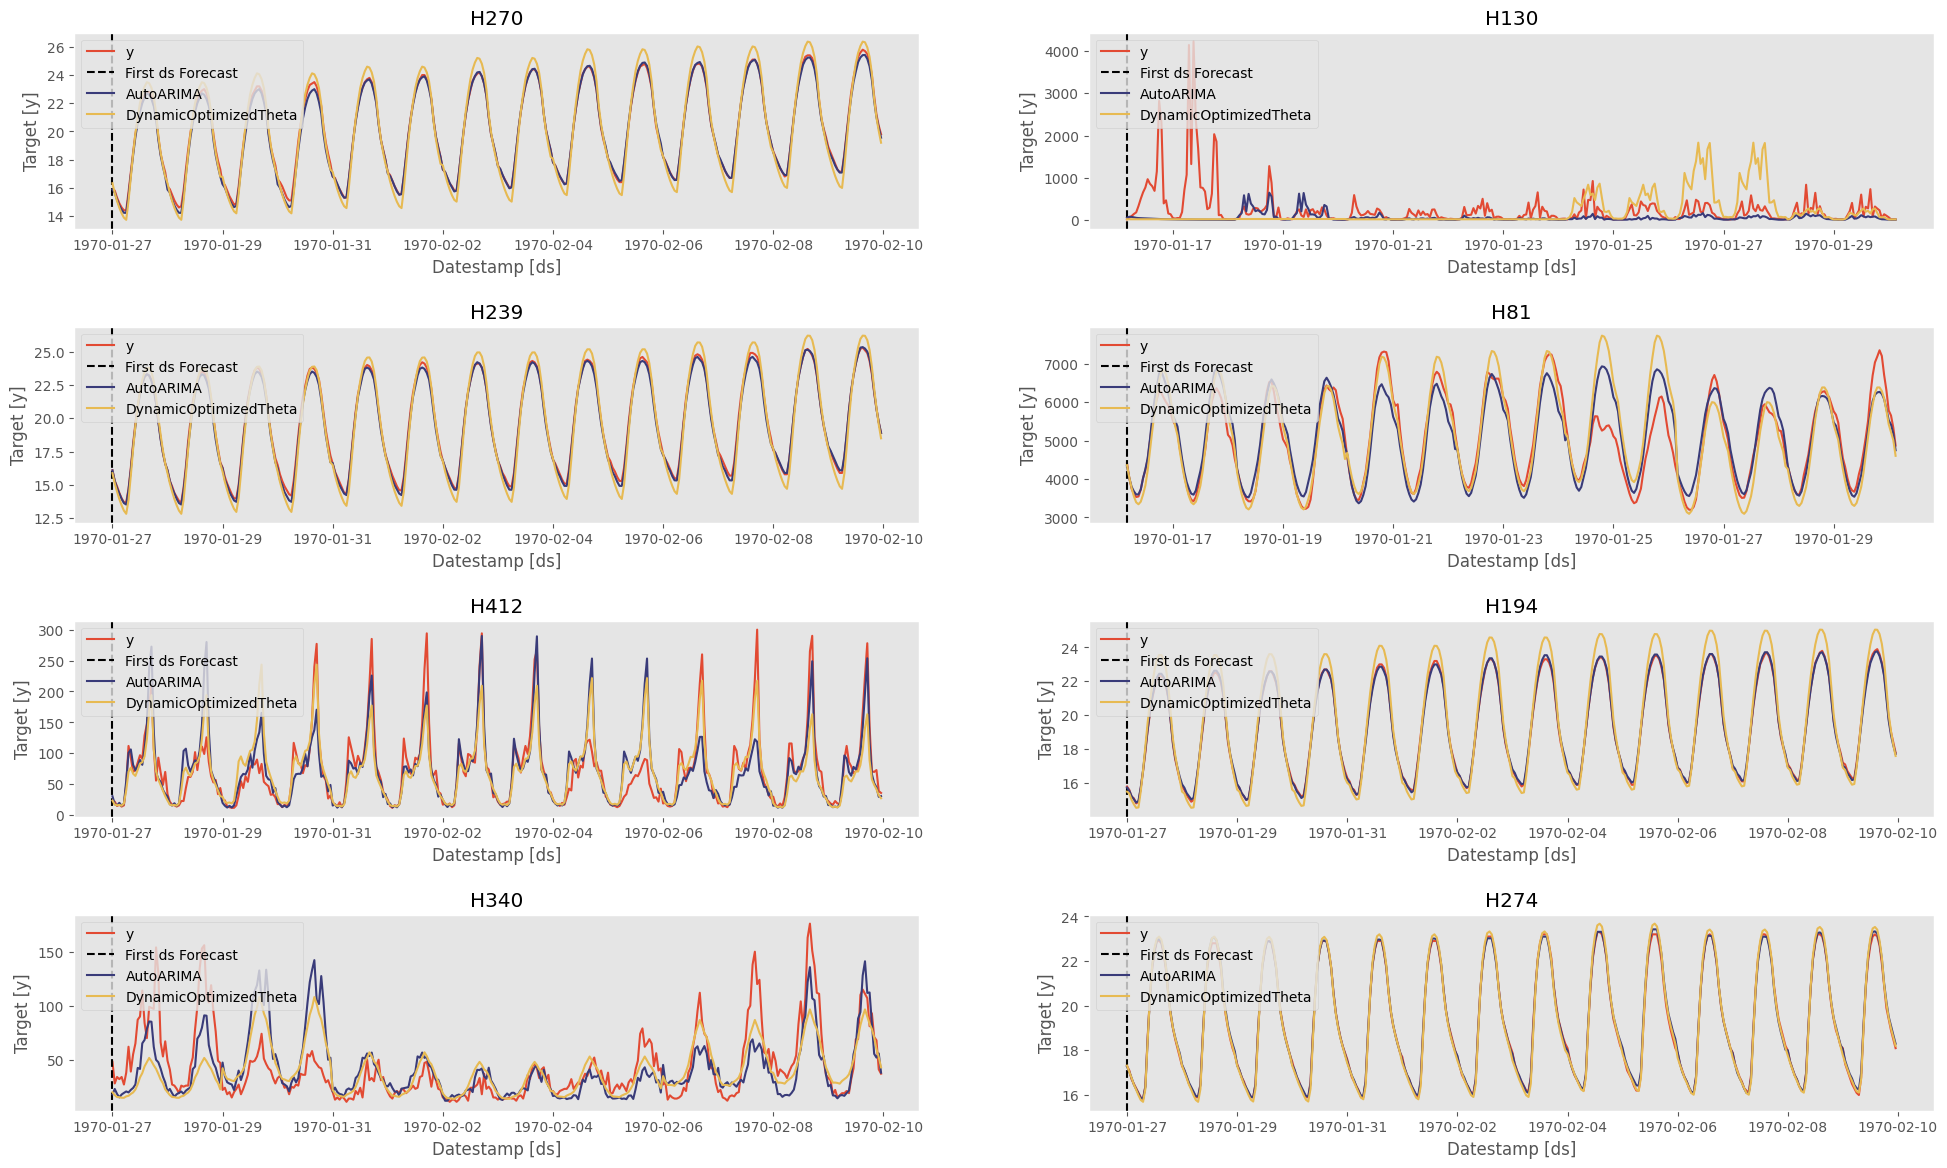

In [25]:
sf.plot(test_data, y_hat_df, engine='matplotlib')

In [15]:
y_hat_df_arima = y_hat_df.reset_index().iloc[:, [0, 1, 2]].rename(columns={'AutoARIMA' : 'y_hat'})
y_hat_df_theta = y_hat_df.reset_index().iloc[:, [0, 1, 3]].rename(columns={'DynamicOptimizedTheta' : 'y_hat'})

In [17]:
y_hat_df_theta

,unique_id,ds,y_hat
0,H1,1970-01-16 04:00:00,669.021484
1,H1,1970-01-16 05:00:00,600.405457
2,H1,1970-01-16 06:00:00,548.027710
3,H1,1970-01-16 07:00:00,512.145447
4,H1,1970-01-16 08:00:00,490.007324
...,...,...,...
139099,H99,1970-01-29 23:00:00,23321.707031
139100,H99,1970-01-30 00:00:00,22631.177734
139101,H99,1970-01-30 01:00:00,22217.933594
139102,H99,1970-01-30 02:00:00,21835.824219


In [18]:
y_hat_df_arima.to_csv('../results/m4/base_model_train_set/y_hat_df_arima_ts.csv', index=False)
y_hat_df_theta.to_csv('../results/m4/base_model_train_set/y_hat_df_theta_ts.csv', index=False)

### XGBoost

In [26]:
prediction_length = 48

In [27]:
index_cutoffs = [48*i for i in range(7, 0, -1)]
index_cutoffs

[336, 288, 240, 192, 144, 96, 48]

In [28]:
cutoffs = [y_train_df.groupby('unique_id')['ds'].transform(lambda x: x.max() - pd.Timedelta(hours=index_cutoff)) for index_cutoff in index_cutoffs]
ceilings = [x + pd.Timedelta(hours=48) for x in cutoffs]
training_data_list = [y_train_df[y_train_df['ds'] <= cutoff] for cutoff in cutoffs]
test_data_list = [y_train_df[(y_train_df['ds'] > cutoff) & (y_train_df['ds'] <= ceiling)] for cutoff, ceiling in zip(cutoffs, ceilings)]

In [29]:
import numpy as np
import pandas as pd
import xgboost as xgb
from typing import Tuple
from sklearn.multioutput import MultiOutputRegressor

In [30]:
target_variable = 'y'
timestemp_col = 'ds'

hyperparameters = {
    "in_length": 7*24,             # Using 7 days (168 hours) of past observations
    "step_size": 24,               # Sliding the window by 24 steps each time
    "target_sequence_length": prediction_length, # Forecasting 48 hours ahead
    "n_estimators": 20,            # Number of gradient boosted trees
    "max_depth": 6,                # Maximum depth of a tree
    "subsample": 0.5,              # Fraction of samples to be used for fitting each tree
    "min_child_weight": 1,         # Minimum sum of instance weight (hessian) needed in a child
    "selected_features": [target_variable]  # Features selected for training the model
}

In [31]:
def get_indices_entire_sequence(data: pd.DataFrame, hyperparameters: dict) -> list:
    """
    Produce all the start and end index positions that are needed to produce
    the sub-sequences for the dataset.

    Args:
        data (pd.DataFrame): Partitioned data set, e.g., training data
        hyperparameters (dict): A dictionary containing the hyperparameters
        
    Return:
        indices: a list of tuples
    """

    window_size = hyperparameters['in_length'] + hyperparameters['target_sequence_length']
    step_size = hyperparameters['step_size']
    stop_position = len(data) - 1

    subseq_first_idx = 0
    subseq_last_idx = window_size

    indices = []

    while subseq_last_idx < stop_position:
        indices.append((subseq_first_idx, subseq_last_idx))
        subseq_first_idx += step_size
        subseq_last_idx += step_size

    return indices

In [32]:
def get_x_y(
        indices: list,
        data: pd.DataFrame,
        target_variable: str,
        target_sequence_length: int,
        input_seq_len: int
) -> Tuple[np.array, np.array]:
    
    print ("Preparing data...")
    """
    Obtaining the model inputs and targets (X,Y)
    """
    
    y_data = data[target_variable].values

    for i, idx in enumerate(indices):

        data_instance = y_data[idx[0]:idx[1]]

        x = data_instance[0: input_seq_len]
        y = data_instance[input_seq_len:input_seq_len + target_sequence_length]

        assert len(x) == input_seq_len
        assert len(y) == target_sequence_length

        if i == 0:
            X = x.reshape(1, -1)
            Y = y.reshape(1, -1)
        else:
            X = np.concatenate((X, x.reshape(1, -1)), axis=0)
            Y = np.concatenate((Y, y.reshape(1, -1)), axis=0)

    print ("Finished preparing data!")

    return X, Y

In [36]:
y_hat_df_xgb = pd.DataFrame()

for series_id in training_data['unique_id'].unique():
# for series_id in ['H1','H10']:

    print(f"Processing {series_id}...")

    for training_data, test_data in zip(training_data_list, test_data_list):

        print(f"Processing {series_id}...")

        # training_data = training_data_list[0]
        # test_data = test_data_list[0]

        series_train = training_data[training_data['unique_id'] == series_id]
        series_test = test_data[test_data['unique_id'] == series_id]

        training_indices = get_indices_entire_sequence(
            data=series_train,
            hyperparameters=hyperparameters)

        x_train, y_train = get_x_y(
            indices=training_indices, 
            data=series_train[hyperparameters["selected_features"]],
            target_variable=target_variable,
            target_sequence_length=hyperparameters["target_sequence_length"],
            input_seq_len=hyperparameters["in_length"]
        )


        model = xgb.XGBRegressor(
            n_estimators=hyperparameters["n_estimators"],
            max_depth=hyperparameters["max_depth"],
            subsample=hyperparameters["subsample"],
            min_child_weight=hyperparameters["min_child_weight"],
            objective="reg:squarederror",
            tree_method="hist"
        )

        trained_model = MultiOutputRegressor(model).fit(x_train, y_train)

        x_test = series_train[hyperparameters["selected_features"]].iloc[-hyperparameters["in_length"]:].to_numpy().reshape(1, -1)

        y_hat = trained_model.predict(x_test).reshape(-1, 1)

        series_predictions = pd.DataFrame({
        'unique_id': series_id,
        'ds': series_test['ds'].values,  
        'y_hat': y_hat.squeeze()
        })

        y_hat_df_xgb = pd.concat([y_hat_df_xgb, series_predictions], axis=0)

    print(y_hat_df_xgb)
    print(f"Finished {series_id}!") 



Processing H1...
Processing H1...
Preparing data...
Finished preparing data!
Processing H1...
Preparing data...
Finished preparing data!
Processing H1...
Preparing data...
Finished preparing data!
Processing H1...
Preparing data...
Finished preparing data!
Processing H1...
Preparing data...
Finished preparing data!
Processing H1...
Preparing data...
Finished preparing data!
Processing H1...
Preparing data...
Finished preparing data!
   unique_id                  ds       y_hat
0         H1 1970-01-16 04:00:00  809.200439
1         H1 1970-01-16 05:00:00  766.519470
2         H1 1970-01-16 06:00:00  746.713562
3         H1 1970-01-16 07:00:00  700.945129
4         H1 1970-01-16 08:00:00  647.885986
..       ...                 ...         ...
43        H1 1970-01-29 23:00:00  843.173035
44        H1 1970-01-30 00:00:00  839.091980
45        H1 1970-01-30 01:00:00  897.307129
46        H1 1970-01-30 02:00:00  864.090454
47        H1 1970-01-30 03:00:00  803.895203

[336 rows x 3 columns]

In [37]:
y_hat_df_xgb

,unique_id,ds,y_hat
0,H1,1970-01-16 04:00:00,809.200439
1,H1,1970-01-16 05:00:00,766.519470
2,H1,1970-01-16 06:00:00,746.713562
3,H1,1970-01-16 07:00:00,700.945129
4,H1,1970-01-16 08:00:00,647.885986
...,...,...,...
43,H99,1970-01-29 23:00:00,23015.267578
44,H99,1970-01-30 00:00:00,24357.009766
45,H99,1970-01-30 01:00:00,23570.687500
46,H99,1970-01-30 02:00:00,23651.138672


In [38]:
y_hat_df_xgb.to_csv('../results/m4/base_model_train_set/y_hat_df_xgb_ts.csv', index=False)

### GRU

In [3]:
X_train_df, y_train_df, X_test_df, y_test_df = prepare_m4_data(dataset_name="Hourly",
                                                               directory="../data/M4",
                                                               num_obs=414)

In [4]:
unique_ids = y_train_df['unique_id'].unique()

In [5]:
prediction_length = 48

In [6]:
index_cutoffs = [48*i for i in range(7, 0, -1)]
index_cutoffs

[336, 288, 240, 192, 144, 96, 48]

In [7]:
cutoffs = [y_train_df.groupby('unique_id')['ds'].transform(lambda x: x.max() - pd.Timedelta(hours=index_cutoff)) for index_cutoff in index_cutoffs]
ceilings = [x + pd.Timedelta(hours=48) for x in cutoffs]
training_data_list = [y_train_df[y_train_df['ds'] <= cutoff] for cutoff in cutoffs]
test_data_list = [y_train_df[(y_train_df['ds'] > cutoff) & (y_train_df['ds'] <= ceiling)] for cutoff, ceiling in zip(cutoffs, ceilings)]

In [8]:
test_data = y_train_df[y_train_df['ds'] > cutoffs[0]]

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [10]:
seq_length = 24*7
target_seq_length = prediction_length
input_size = 1
hidden_size = 10
num_layers = 1
output_size = 1
learning_rate = 0.013
epochs = 800
batch_n = 128

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    scaled_data = scaled_data.flatten()

    return scaled_data, scaler
    

In [13]:
def create_sequence(df, unique_id, seq_length):
    # Xs, Ys = [], []
    sequence_dict = {}
    grouped = df.groupby(unique_id)

    for group_id, group in grouped:
        data = group['y'].values
        data, scaler = normalize_data(data)
        X, Y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:(i + seq_length)])
            Y.append(data[i + seq_length])
        sequence_dict[group_id] = {'X' : np.array(X), 'y': np.array(Y), 'scaler' : scaler}

    return sequence_dict

In [14]:
class GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        gru_out, _ = self.gru(x, h0)
        out = self.fc(gru_out[:, -1, :])
        return out

In [15]:
def train_model(model,
                criterion,
                optimizer,
                X_train,
                y_train,
                target_seq_length = target_seq_length,
                batch_size = 64,
                epochs=100):
    
    dataset = TensorDataset(X_train, y_train)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):

        model.train()

        for batch_idx, (sequences, targets) in enumerate(data_loader):

            sequences, targets = sequences.to(device), targets.to(device)

            # put default model grads to zero
            optimizer.zero_grad()

            # predict the output
            pred = model(sequences)

            # calculate the loss
            loss = criterion(pred, targets)

            # backpropagate the error
            loss.backward()

            # update the model parameters
            optimizer.step()

        if (epoch+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

    # generating forecasts
    model.eval()
    last_sequence = X_train[-1:].to(device)
    forecast_seq = torch.Tensor().to(device)

    for _ in range(target_seq_length):
        with torch.no_grad():
            
            next_step_forecast = model(last_sequence)

            forecast_seq = torch.cat((forecast_seq, next_step_forecast[:, -1:]), dim=1)

            last_sequence = torch.cat((last_sequence[:, 1:, :], next_step_forecast[:, -1:].unsqueeze(-1)), dim=1)
    
    return model, forecast_seq

In [17]:
sequences_dict_list = [create_sequence(training_data, 'unique_id', seq_length) for training_data in training_data_list]

In [18]:
y_hat_df_gru = test_data.copy().rename(columns={'y' : 'y_hat'})
y_hat_df_gru['y_hat'] = pd.Series(dtype='float64')

all_forecast_seq_descaled = []

for series_id in unique_ids:
# for series_id in ['H1', 'H10']:

    print(f'Series {series_id}')

    for sequences_dict in sequences_dict_list:
    
        X_train = torch.from_numpy(sequences_dict[series_id]['X'].astype(np.float32)).unsqueeze(-1)
        y_train = torch.from_numpy(sequences_dict[series_id]['y'].astype(np.float32)).unsqueeze(-1)

        model = GRU_Model(input_size, hidden_size, num_layers, output_size)
        model.to(device)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        model_gru, forecast_seq = train_model(model,
                                            criterion=criterion,
                                            optimizer=optimizer,
                                            X_train=X_train,
                                            y_train=y_train,
                                            batch_size=batch_n,
                                            epochs=epochs)
        
        forecast_seq_descaled = sequences_dict[series_id]['scaler'].inverse_transform(forecast_seq.cpu().numpy()).flatten()
        # all_forecast_seq_descaled = np.hstack(all_forecast_seq_descaled, forecast_seq_descaled)
        all_forecast_seq_descaled.append(forecast_seq_descaled)

all_forecast_seq_descaled = np.hstack(all_forecast_seq_descaled)

y_hat_df_gru['y_hat'] = all_forecast_seq_descaled


Series H1
Epoch [200/800], Loss: 0.0016688898904249072
Epoch [400/800], Loss: 0.001518057775683701
Epoch [600/800], Loss: 0.0013265253510326147
Epoch [800/800], Loss: 0.0006868115160614252
Epoch [200/800], Loss: 0.0017642041202634573
Epoch [400/800], Loss: 0.0016034075524657965
Epoch [600/800], Loss: 0.0013959133066236973
Epoch [800/800], Loss: 0.0011355909518897533
Epoch [200/800], Loss: 0.0028611940797418356
Epoch [400/800], Loss: 0.002174899447709322
Epoch [600/800], Loss: 0.0013507616240531206
Epoch [800/800], Loss: 0.0009207551483996212
Epoch [200/800], Loss: 0.0023052406031638384
Epoch [400/800], Loss: 0.0021492992527782917
Epoch [600/800], Loss: 0.001832684618420899
Epoch [800/800], Loss: 0.0012046686606481671
Epoch [200/800], Loss: 0.0024967752397060394
Epoch [400/800], Loss: 0.0017301080515608191
Epoch [600/800], Loss: 0.00023299524036701769
Epoch [800/800], Loss: 0.00048110404168255627
Epoch [200/800], Loss: 0.002044486813247204
Epoch [400/800], Loss: 0.0018033526139333844
Ep

In [19]:
all_forecast_seq_descaled.shape

(139104,)

In [22]:
y_hat_df_gru.reset_index(inplace=True)

In [24]:
y_hat_df_gru.drop(columns=['index'], inplace=True)

In [25]:
y_hat_df_gru

,unique_id,ds,y_hat
0,H1,1970-01-16 04:00:00,746.949951
1,H1,1970-01-16 05:00:00,670.688599
2,H1,1970-01-16 06:00:00,602.008789
3,H1,1970-01-16 07:00:00,556.382935
4,H1,1970-01-16 08:00:00,528.881653
...,...,...,...
139099,H99,1970-01-29 23:00:00,22249.697266
139100,H99,1970-01-30 00:00:00,21826.882812
139101,H99,1970-01-30 01:00:00,20934.566406
139102,H99,1970-01-30 02:00:00,20203.701172


In [26]:
y_hat_df_gru.to_csv('../results/m4/base_model_train_set/y_hat_df_gru_ts.csv', index=False)


### LSTM

In [3]:
X_train_df, y_train_df, X_test_df, y_test_df = prepare_m4_data(dataset_name="Hourly",
                                                               directory="../data/M4",
                                                               num_obs=414)

In [4]:
unique_ids = y_train_df['unique_id'].unique()

In [5]:
prediction_length = 48

In [6]:
index_cutoffs = [48*i for i in range(7, 0, -1)]
index_cutoffs

[336, 288, 240, 192, 144, 96, 48]

In [7]:
cutoffs = [y_train_df.groupby('unique_id')['ds'].transform(lambda x: x.max() - pd.Timedelta(hours=index_cutoff)) for index_cutoff in index_cutoffs]
ceilings = [x + pd.Timedelta(hours=48) for x in cutoffs]
training_data_list = [y_train_df[y_train_df['ds'] <= cutoff] for cutoff in cutoffs]
test_data_list = [y_train_df[(y_train_df['ds'] > cutoff) & (y_train_df['ds'] <= ceiling)] for cutoff, ceiling in zip(cutoffs, ceilings)]

In [8]:
test_data = y_train_df[y_train_df['ds'] > cutoffs[0]]

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [10]:
seq_length = 24*7
target_seq_length = prediction_length
input_size = 1
hidden_size = 10
num_layers = 1
output_size = 1
learning_rate = 0.0075
epochs = 1200
batch_n = 128

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    scaled_data = scaled_data.flatten()

    return scaled_data, scaler
    

In [13]:
def create_sequence(df, unique_id, seq_length):
    # Xs, Ys = [], []
    sequence_dict = {}
    grouped = df.groupby(unique_id)

    for group_id, group in grouped:
        data = group['y'].values
        data, scaler = normalize_data(data)
        X, Y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:(i + seq_length)])
            Y.append(data[i + seq_length])
        sequence_dict[group_id] = {'X' : np.array(X), 'y': np.array(Y), 'scaler' : scaler}

    return sequence_dict

In [14]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        out = self.fc(lstm_out[:, -1, :])
        return out

In [15]:
def train_model(model,
                criterion,
                optimizer,
                X_train,
                y_train,
                target_seq_length = target_seq_length,
                batch_size = 64,
                epochs=100):
    
    dataset = TensorDataset(X_train, y_train)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):

        model.train()

        for batch_idx, (sequences, targets) in enumerate(data_loader):

            sequences, targets = sequences.to(device), targets.to(device)

            # put default model grads to zero
            optimizer.zero_grad()

            # predict the output
            pred = model(sequences)

            # calculate the loss
            loss = criterion(pred, targets)

            # backpropagate the error
            loss.backward()

            # update the model parameters
            optimizer.step()

        if (epoch+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

    # generating forecasts
    model.eval()
    last_sequence = X_train[-1:].to(device)
    forecast_seq = torch.Tensor().to(device)

    for _ in range(target_seq_length):
        with torch.no_grad():
            
            next_step_forecast = model(last_sequence)

            forecast_seq = torch.cat((forecast_seq, next_step_forecast[:, -1:]), dim=1)

            last_sequence = torch.cat((last_sequence[:, 1:, :], next_step_forecast[:, -1:].unsqueeze(-1)), dim=1)
    
    return model, forecast_seq

In [16]:
sequences_dict_list = [create_sequence(training_data, 'unique_id', seq_length) for training_data in training_data_list]

In [17]:
y_hat_df_lstm = test_data.copy().rename(columns={'y' : 'y_hat'})
y_hat_df_lstm['y_hat'] = pd.Series(dtype='float64')

all_forecast_seq_descaled = []

for series_id in unique_ids:
# for series_id in ['H1', 'H10']:

    print(f'Series {series_id}')

    for sequences_dict in sequences_dict_list:
    
        X_train = torch.from_numpy(sequences_dict[series_id]['X'].astype(np.float32)).unsqueeze(-1)
        y_train = torch.from_numpy(sequences_dict[series_id]['y'].astype(np.float32)).unsqueeze(-1)

        model = LSTM_Model(input_size, hidden_size, num_layers, output_size)
        model.to(device)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        model_gru, forecast_seq = train_model(model,
                                            criterion=criterion,
                                            optimizer=optimizer,
                                            X_train=X_train,
                                            y_train=y_train,
                                            batch_size=batch_n,
                                            epochs=epochs)
        
        forecast_seq_descaled = sequences_dict[series_id]['scaler'].inverse_transform(forecast_seq.cpu().numpy()).flatten()
        # all_forecast_seq_descaled = np.hstack(all_forecast_seq_descaled, forecast_seq_descaled)
        all_forecast_seq_descaled.append(forecast_seq_descaled)

all_forecast_seq_descaled = np.hstack(all_forecast_seq_descaled)

y_hat_df_lstm['y_hat'] = all_forecast_seq_descaled


Series H1
Epoch [200/1200], Loss: 0.0016957598272711039
Epoch [400/1200], Loss: 0.008355049416422844
Epoch [600/1200], Loss: 0.000892098352778703
Epoch [800/1200], Loss: 0.001336901099421084
Epoch [1000/1200], Loss: 0.0008689776877872646
Epoch [1200/1200], Loss: 0.002114903647452593
Epoch [200/1200], Loss: 0.0023729626554995775
Epoch [400/1200], Loss: 0.0010399644961580634
Epoch [600/1200], Loss: 0.0008178314892575145
Epoch [800/1200], Loss: 0.0007284969324246049
Epoch [1000/1200], Loss: 0.000661723199300468
Epoch [1200/1200], Loss: 0.0006042079185135663
Epoch [200/1200], Loss: 0.002647567540407181
Epoch [400/1200], Loss: 0.0017687587533146143
Epoch [600/1200], Loss: 0.0018510903464630246
Epoch [800/1200], Loss: 0.0008407945861108601
Epoch [1000/1200], Loss: 0.0005533574149012566
Epoch [1200/1200], Loss: 0.00048653854173608124
Epoch [200/1200], Loss: 0.002757617272436619
Epoch [400/1200], Loss: 0.0011515283258631825
Epoch [600/1200], Loss: 0.001014413544908166
Epoch [800/1200], Loss: 0

In [75]:
y_hat_df_lstm.reset_index(drop=True, inplace=True)

In [18]:
y_hat_df_lstm

,unique_id,ds,y_hat
364,H1,1970-01-16 04:00:00,759.249695
365,H1,1970-01-16 05:00:00,713.247131
366,H1,1970-01-16 06:00:00,659.009155
367,H1,1970-01-16 07:00:00,599.360413
368,H1,1970-01-16 08:00:00,541.235291
...,...,...,...
353495,H99,1970-01-29 23:00:00,23991.683594
353496,H99,1970-01-30 00:00:00,23624.857422
353497,H99,1970-01-30 01:00:00,22799.708984
353498,H99,1970-01-30 02:00:00,22155.929688


In [19]:
y_hat_df_lstm.to_csv('../results/m4/base_model_train_set/y_hat_df_lstm_ts.csv', index=False)
